# Monte Carlo Ferromagnet
\begin{equation}
    {\cal H} = -J \sum_{<i,j>} S^z_i S_j^z
\end{equation}

In [1]:
using PyPlot;
push!(LOAD_PATH,".")
using Lattices;

In [17]:
l=10;
beta=1.1;
J=1;
t=1000;
tburnin=0;

Members of Type
* name  , a string
* l , length in number of unit cells
* dim, dimension of lattice
* a, array containing the basis vectors by which positions are generated
* unit. array of positions inside a single unit
* N , number of total sites
* X, array of positions
* nnei, number of nearest neighbors
* neigh, Array of nearest neighbors [i][j], where i is site and j is 1:nnei

In [3]:
sq=MakeLattice("Square",l);
S=ones(Int8,sq.N);

In [4]:
function dE(i::Int)
    Eii=0;
    for j in 1:sq.nnei
        Eii+=S[sq.neigh[i,j]];
    end
    Eii*=-J*S[i];
    return Eii;
end
function E()
    Evar=0;
    for k in 1:sq.N
        Evar+=.5*dE(k);
    end
    return Evar;
end

E (generic function with 1 method)

In [8]:
changed=[]

0-element Array{Any,1}

In [27]:
beta=.5

0.5

In [32]:
changed=[]
for dt in -tburnin:t
    for j in 1:sq.N
        i = rand(1:sq.N);
        de=dE(i);
        if(de>0 || rand()<exp(2*beta*de) )
            S[i]=-S[i];
            push!(changed,dt)
        end
        
    end
end
size(changed)

(7373,)

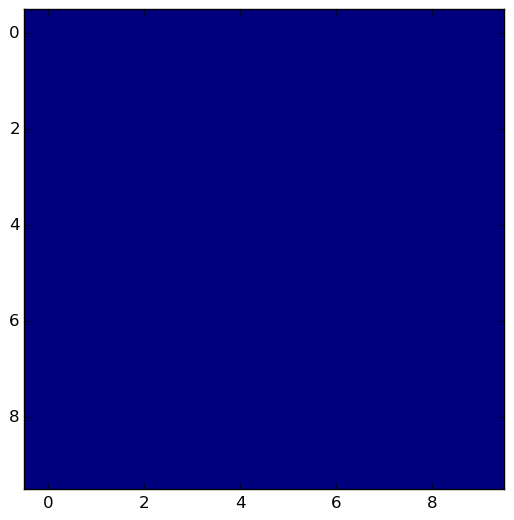

PyObject <matplotlib.image.AxesImage object at 0x7fde1887d810>

In [33]:
imshow(reshape(S,10,10))

748-element Array{Any,1}:
  7
 38
 41
 60
 97
  5
 45
 54
 57
 69
 72
 89
  1
  ⋮
 22
 44
 48
 49
 53
 58
 59
 61
 65
 90
 93
 94